In [1]:
from pathlib import Path
from models import utils as mutils
#from sde_lib import VESDE
from sampling_annealed import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      get_pc_fouriercs_fast)
from models import ncsnpp
import time
from utils import fft2, ifft2, get_mask, get_data_scaler, get_data_inverse_scaler, restore_checkpoint
import torch
import torch.nn as nn
import numpy as np
from models.ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import importlib
import argparse
from PIL import Image
import abc

In [2]:
N = 10
m = 3
configs = importlib.import_module(f"configs.ve.fastmri_knee_320_ncsnpp_continuous")
config = configs.get_config()
img_size = config.data.image_size
batch_size = 1
print('initializing...')

initializing...


# VE-SDE Class

In [3]:
class SDE(abc.ABC):
  """SDE abstract class. Functions are designed for a mini-batch of inputs."""

  def __init__(self, N):
    """Construct an SDE.

    Args:
      N: number of discretization time steps.
    """
    super().__init__()
    self.N = N

  @property
  @abc.abstractmethod
  def T(self):
    """End time of the SDE."""
    pass

  @abc.abstractmethod
  def sde(self, x, t):
    pass

  @abc.abstractmethod
  def marginal_prob(self, x, t):
    """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
    pass

  @abc.abstractmethod
  def prior_sampling(self, shape):
    """Generate one sample from the prior distribution, $p_T(x)$."""
    pass

  @abc.abstractmethod
  def prior_logp(self, z):
    """Compute log-density of the prior distribution.

    Useful for computing the log-likelihood via probability flow ODE.

    Args:
      z: latent code
    Returns:
      log probability density
    """
    pass

  def discretize(self, x, t):
    """Discretize the SDE in the form: x_{i+1} = x_i + f_i(x_i) + G_i z_i.

    Useful for reverse diffusion sampling and probabiliy flow sampling.
    Defaults to Euler-Maruyama discretization.

    Args:
      x: a torch tensor
      t: a torch float representing the time step (from 0 to `self.T`)

    Returns:
      f, G
    """
    dt = 1 / self.N
    drift, diffusion = self.sde(x, t)
    f = drift * dt
    G = diffusion * torch.sqrt(torch.tensor(dt, device=t.device))
    return f, G

  def reverse(self, score_fn, probability_flow=False):
    """Create the reverse-time SDE/ODE.

    Args:
      score_fn: A time-dependent score-based model that takes x and t and returns the score.
      probability_flow: If `True`, create the reverse-time ODE used for probability flow sampling.
    """
    N = self.N
    T = self.T
    sde_fn = self.sde
    discretize_fn = self.discretize

    # Build the class for reverse-time SDE.
    class RSDE(self.__class__):
      def __init__(self):
        self.N = N
        self.probability_flow = probability_flow

      @property
      def T(self):
        return T

      def sde(self, x, t):
        """Create the drift and diffusion functions for the reverse SDE/ODE."""
        drift, diffusion = sde_fn(x, t)
        score = score_fn(x, t)
        drift = drift - diffusion[:, None, None, None] ** 2 * score * (0.5 if self.probability_flow else 1.)
        # Set the diffusion function to zero for ODEs.
        diffusion = 0. if self.probability_flow else diffusion
        return drift, diffusion

      def discretize(self, x, t):
        """Create discretized iteration rules for the reverse diffusion sampler."""
        f, G = discretize_fn(x, t)
        rev_f = f - G[:, None, None, None] ** 2 * score_fn(x, t) * (0.5 if self.probability_flow else 1.)
        rev_G = torch.zeros_like(G) if self.probability_flow else G
        return rev_f, rev_G

    return RSDE()

In [4]:
class VESDE(SDE):
  def __init__(self, x0, sigma_min=0.01, sigma_max=50, N=1000):
    """Construct a Variance Exploding SDE.

    Args:
      sigma_min: smallest sigma.
      sigma_max: largest sigma.
      N: number of discretization steps
    """
    super().__init__(N)
    self.sigma_min = sigma_min
    self.sigma_max = sigma_max
    self.discrete_sigmas = torch.exp(torch.linspace(np.log(self.sigma_min), np.log(self.sigma_max), N))
    self.N = N
    self.x0 = x0

  @property
  def T(self):
    return 1

  def sde(self, x, t):
    sigma = self.sigma_min * (self.sigma_max / self.sigma_min) ** t
    drift = torch.zeros_like(x)
    diffusion = sigma * torch.sqrt(torch.tensor(2 * (np.log(self.sigma_max) - np.log(self.sigma_min)),
                                                device=t.device))
    return drift, diffusion

  def marginal_prob(self, x, t):
    std = self.sigma_min * (self.sigma_max / self.sigma_min) ** t
    mean = x
    return mean, std

  def prior_sampling(self, shape):
    return self.x0 + torch.randn(*shape) * self.sigma_max

  def prior_logp(self, z):
    shape = z.shape
    N = np.prod(shape[1:])
    return -N / 2. * np.log(2 * np.pi * self.sigma_max ** 2) - torch.sum(z ** 2, dim=(1, 2, 3)) / (2 * self.sigma_max ** 2)

  def discretize(self, x, t):
    """SMLD(NCSN) discretization."""
    timestep = (t * (self.N - 1) / self.T).long()
    sigma = self.discrete_sigmas.to(t.device)[timestep]
    adjacent_sigma = torch.where(timestep == 0, torch.zeros_like(t),
                                 self.discrete_sigmas[timestep - 1].to(t.device))
    f = torch.zeros_like(x)
    G = torch.sqrt(sigma ** 2 - adjacent_sigma ** 2)
    return f, G

In [5]:
# Read data
knee_motion = torch.from_numpy(np.load('inputs/001.npy'))
img = knee_motion.view(1, 1, 320, 320)
img = img.to(config.device)

In [6]:
def get_kspace(image):
    kspace = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image,axes=[0,1]),norm='ortho',axes=[0,1]),axes=[0,1])
    return kspace

In [7]:
fft_trans = get_kspace(knee_motion)

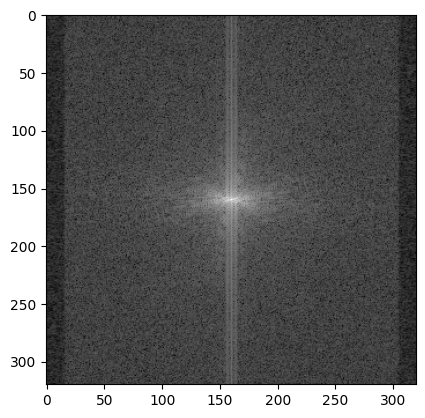

In [8]:
plt.imshow(np.log(1e-3+np.abs(fft_trans)),cmap="gray")

In [9]:
def create_rectangular_mask(shape, width):
    rows, cols = shape
    mask = np.zeros((rows, cols))
    center_row, center_col = rows // 2, cols // 2
    mask[center_row - width // 2:center_row + width // 2,:] = 1
    return mask

In [10]:
mask = create_rectangular_mask(fft_trans.shape, width=64)

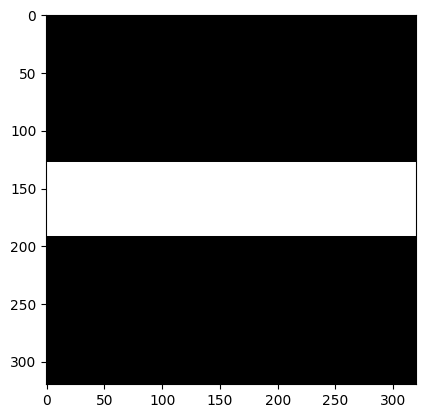

In [11]:
plt.imshow(mask, cmap="gray")

In [12]:
mask_t =  torch.tensor(mask).view(1, 1, 320, 320)
mask_t.shape

torch.Size([1, 1, 320, 320])

# Initialize SDE

In [26]:
sde = VESDE(x0=img, sigma_min=0.01, sigma_max=50, N=300)

In [27]:
config.training.batch_size = batch_size
predictor = ReverseDiffusionPredictor
corrector = LangevinCorrector
probability_flow = False
snr = 0.16

In [28]:
scaler = get_data_scaler(config)
inverse_scaler = get_data_inverse_scaler(config)

# create model and load checkpoint
score_model = mutils.create_model(config)
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, model=score_model, ema=ema)

ckpt_filename = f"./weights/checkpoint_95.pth"
state = restore_checkpoint(ckpt_filename, state, config.device, skip_sigma=True)
ema.copy_to(score_model.parameters())

loaded checkpoint dir from ./weights/checkpoint_95.pth


In [29]:
# Specify save directory for saving generated samples
save_root = Path(f'./results_annealed/real')
save_root.mkdir(parents=True, exist_ok=True)

irl_types = ['input', 'recon', 'recon_progress', 'label']
for t in irl_types:
    save_root_f = save_root / t
    save_root_f.mkdir(parents=True, exist_ok=True)

# 2. Inference

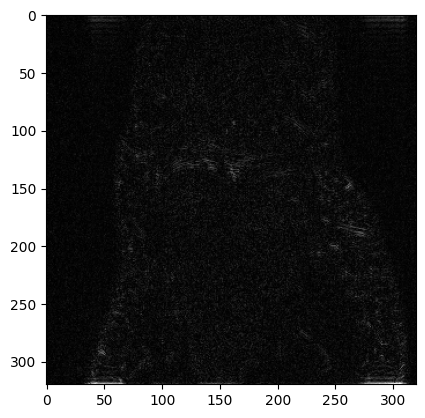

In [30]:
plt.imshow(np.abs((img-ifft2(mask_t*fft2(img))).squeeze().numpy()),cmap="gray")

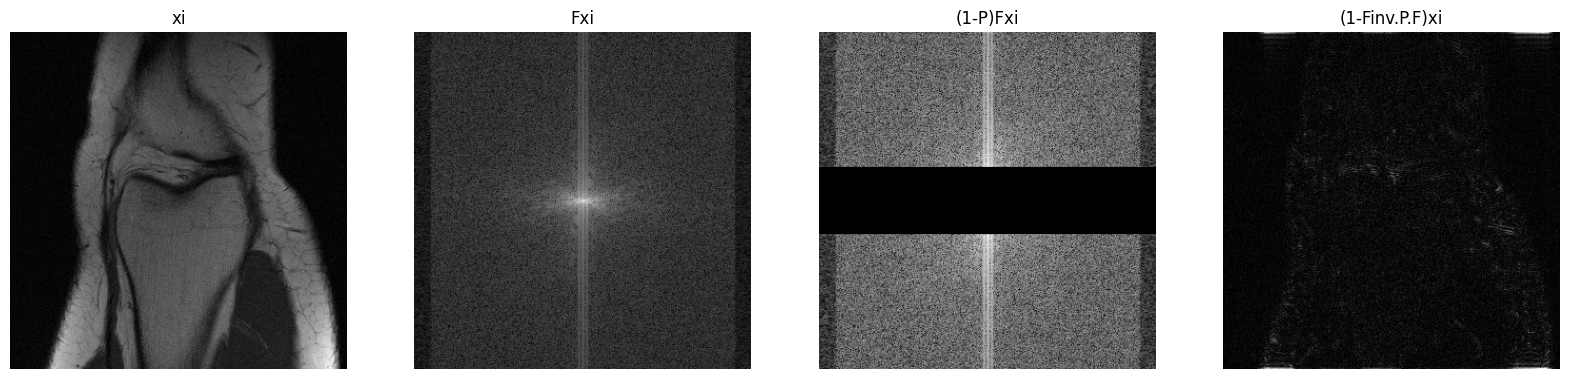

In [31]:
xi_fft = (1-mask_t)*fft2(img)
xi_ifft = ifft2(xi_fft) 
#xi_ifft = img - ifft2(mask_t*fft2(img))

plt.figure(figsize=(20, 20))

plt.subplot(1, 4, 1)
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title('xi')
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(np.log(1+np.abs(fft2(img))).squeeze().numpy(), cmap='gray')  # You can specify colormap according to your needs
plt.title(f"Fxi")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(np.log(1+np.abs(xi_fft)).squeeze().numpy(), cmap='gray')  # Use 'hsv' colormap for phase
plt.title('(1-P)Fxi')
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(np.abs(xi_ifft).squeeze().numpy(), cmap='gray')  # Use 'hsv' colormap for phase
plt.title('(1-Finv.P.F)xi')
plt.axis("off")

# plt.colorbar()  # Add color bar for phase
plt.show()

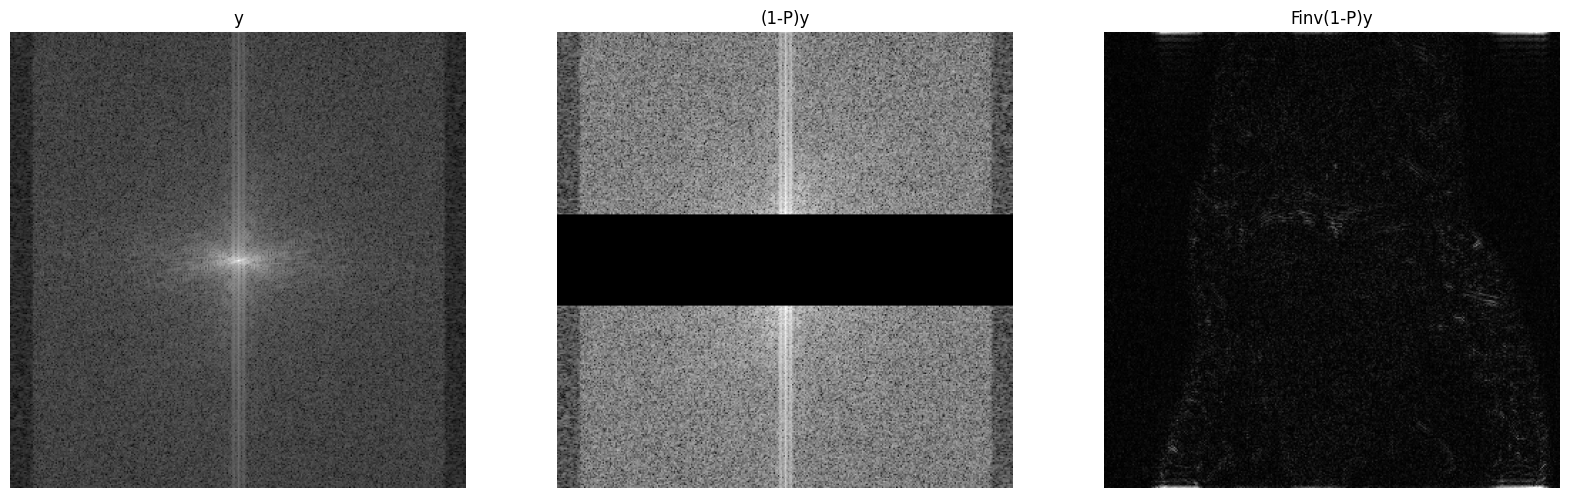

In [32]:
y = get_kspace(knee_motion)
y_mask = (1-mask_t)*y
y_mask_inv = np.fft.ifftshift(ifft2(y_mask))

y_disp = y.squeeze()
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(np.log(1e-3+np.abs(y_disp)), cmap='gray')
plt.title('y')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.log(1e-3+np.abs(y_mask)).squeeze().numpy(), cmap='gray')  # You can specify colormap according to your needs
plt.title("(1-P)y")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(y_mask_inv).squeeze(), cmap='gray')  # Use 'hsv' colormap for phase
plt.title('Finv(1-P)y')
plt.axis("off")

# plt.colorbar()  # Add color bar for phase
plt.show()

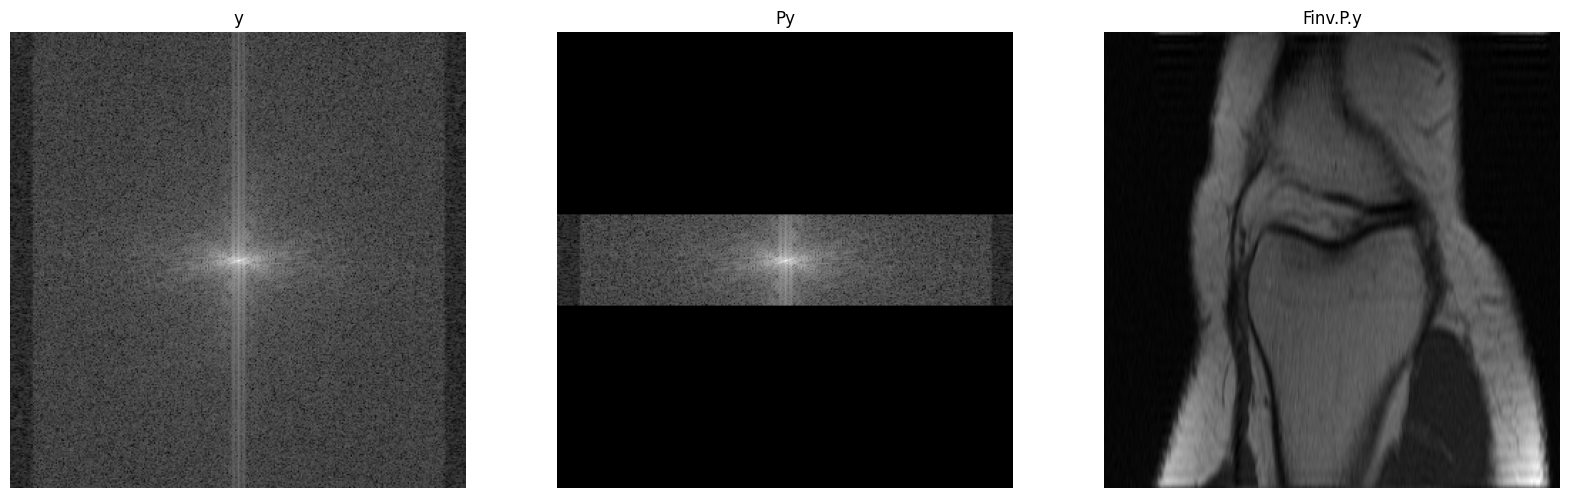

In [33]:
y = get_kspace(knee_motion)
y_mask2 = mask_t*y
y_mask2_inv = np.fft.ifftshift(ifft2(y_mask2))


plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(np.log(1e-3+np.abs(y.squeeze())), cmap='gray')
plt.title('y')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.log(1e-3+np.abs(y_mask2)).squeeze().numpy(), cmap='gray')  
plt.title("Py")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(y_mask2_inv).squeeze(), cmap='gray')  # You can specify colormap according to your needs
plt.title("Finv.P.y")
plt.axis("off")
# plt.colorbar()  # Add color bar for phase
plt.show()

In [34]:
data = scaler(img)

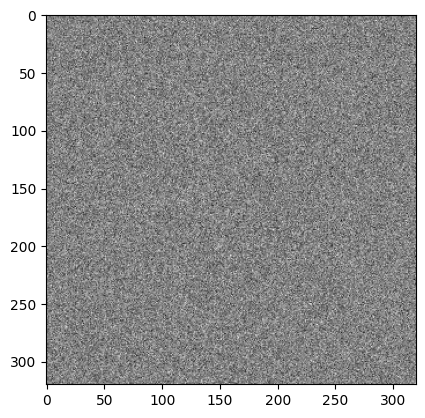

In [35]:
data_with_noise = sde.prior_sampling(data.shape).to(data.device)
plt.imshow(data_with_noise.squeeze().numpy(),cmap="gray")

# Initializing pc_fouriercs

In [36]:
pc_fouriercs = get_pc_fouriercs_fast(sde,
                                     predictor, corrector,
                                     inverse_scaler,
                                     snr=snr,
                                     n_steps=m,
                                     probability_flow=probability_flow,
                                     continuous=config.training.continuous,
                                     denoise=True,
                                     save_progress=True,
                                     save_root=save_root / 'recon_progress')
# fft - kspace
y = torch.real(torch.tensor(get_kspace(knee_motion))).float()

mask_t = mask_t.float()

In [ ]:
print(f'Beginning inference')
tic = time.time()
Lambda_N = 0.01
x = pc_fouriercs(score_model, scaler(img), mask_t, Lambda_N, y=y)
toc = time.time() - tic
print(f'Time took for recon: {toc} secs.')

Beginning inference


  5%|███▋                                                                           | 14/300 [05:16<1:47:36, 22.58s/it]

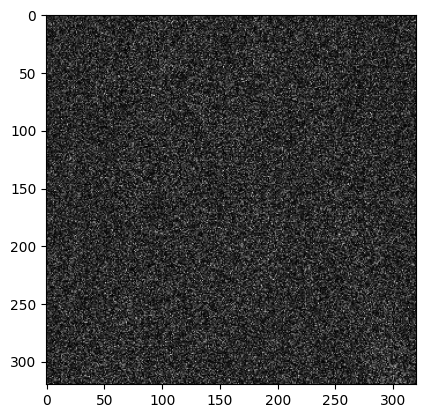

In [39]:
sde = VESDE(x0=img, sigma_min=0.01, sigma_max=1, N=100)

display = ifft2(y + fft2(sde.prior_sampling(data.shape).to(data.device)))
plt.imshow(np.abs(display.squeeze().numpy()),cmap="gray")
